# Семинар 06 – Деревья решений

In [1]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install sklearn
!pip install pydot

  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/a7/e4/463fd46922e0b0b369305662f85f1c70dcc1cde1584906cf8defed8308a3/pydot-3.0.2-py3-none-any.whl.metadata


<a id="Content"></a>
# Содержание
0. [Построение дерева решений](#0)
1. [Деревья решений](#1)
   - [Деревья решений в sklearn](#1.1)
   - [Визуализация обученного дерева](#1.2)
   - [Переобучение дерева](#1.3)
   - [Чувствительность дерева к выборкам](#1.4)
   - [Регрессионные решающие деревья](#1.5)
   - [Применение на реальных данных](#1.6)
2. [Композиция алгоритмов](#2)
   - [Bias-Variance decomposition](#2.1)
   - [Предобработка данных](#2.2)
   - [Bootstrap](#2.3)
   - [Bagging (Bootstrap aggregating)](#2.4)
   - [Random Forest](#2.5)
   - [Out-of-bag error](#2.6)
   - [Ассамблирование алгоритмов разных классов (Blending, Stacking)](#2.7)

<a id="0"></a>
# 0. Построение дерева решений


Источник: [mlcourse.ai](https://mlcourse.ai) от [Юрия Кашницкого](https://yorko.github.io) и [OpenDataScience](https://ods.ai)

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, нужно построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. 

Text(0, 0.5, '$y$')

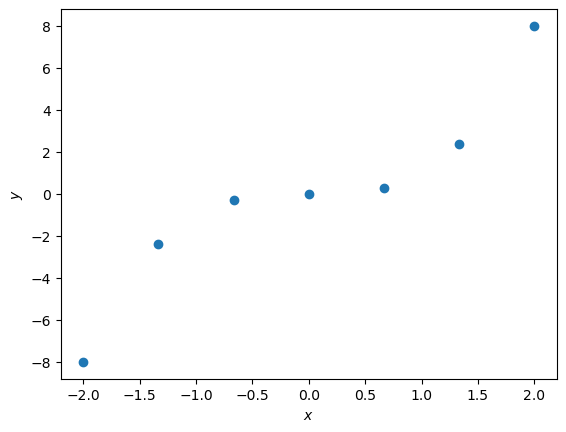

In [7]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку.

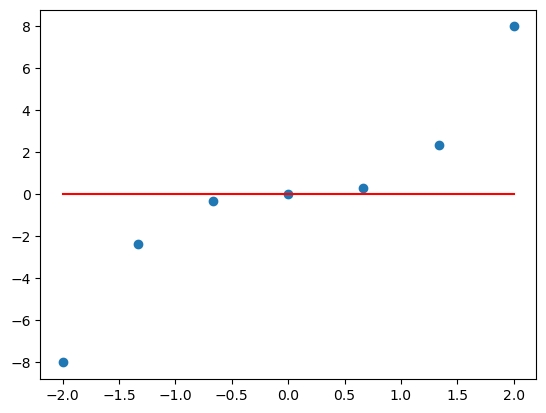

In [11]:
xx = np.linspace(-2, 2, 100)
pred = [np.mean(y) for x in xx]

plt.scatter(X, y);
plt.plot(xx, pred, c='red');

**Задание 0**: Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

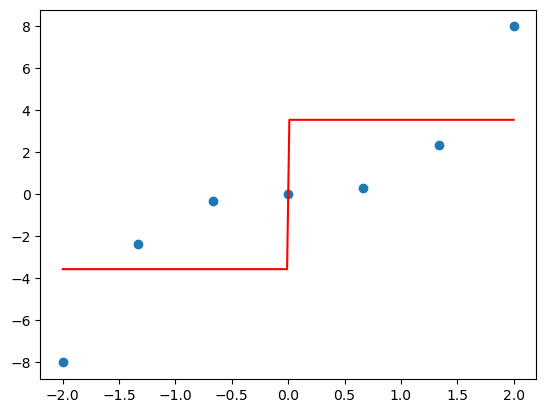

In [14]:
xx = np.linspace(-2, 2, 200)
pred = #YOUR_CODE_HERE

plt.scatter(X, y);
plt.plot(xx, pred, c='red');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий: $$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$ где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[xj < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$: $$D(X) = \dfrac{1}{|X|} \sum{x_j \in X}(y_j – \dfrac{1}{|X|}\sum{x_i \in X}y_i)^2,$$ где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине), а $D$ равняется: $$D = \frac{1}{|X|} \sum_{i=1}^{|X|}(y_{i} - \overline{y})^2$$
где $\overline{y} = \frac{1}{|X|} \sum_{i=1}^{|X|}y_{i}$

Формула для нашего случая:
$$Q(X, y, t) = D(y) - \dfrac{|X_l|}{|X|} D(y_l) - \dfrac{|X_r|}{|X|} D(y_r),$$

**Задание 1**: Реализуйте функцию для $D$ по формуле выше. Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [16]:
X, y

(array([-2.        , -1.33333333, -0.66666667,  0.        ,  0.66666667,
         1.33333333,  2.        ]),
 array([-8.        , -2.37037037, -0.2962963 ,  0.        ,  0.2962963 ,
         2.37037037,  8.        ]))

In [17]:
def D(y):
    #YOUR_CODE_HERE
    pass

In [18]:
def Qc(X, y, t):
    #YOUR_CODE_HERE
    pass

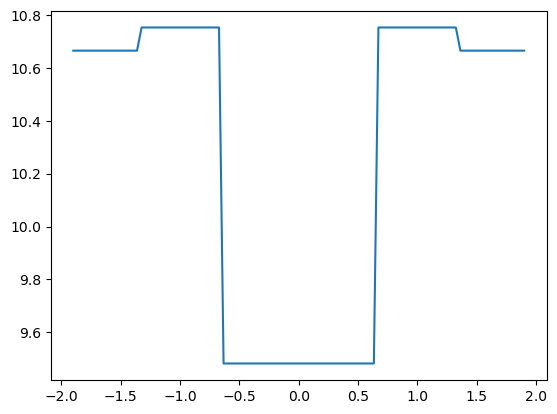

In [19]:
t = np.linspace(-1.9, 1.9, 100)
Q = [Qc(X, y, ti) for ti in t]
plt.plot(t, Q)

<a id="1"></a>
# 1. Деревья решений

<a id="1.1"></a>
## 1.1. Деревья решений в sklearn

In [20]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, roc_auc_score #classification

%matplotlib inline

Для нагляности в качестве простого примера, возьмем всем известные ирисы

In [21]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:] # petal length and width

In [22]:
target_names = iris.target_names
feature_names = iris.feature_names[2:]

y = iris.target

In [23]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [24]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

<a id="1.2"></a>
## 1.2. Визуализация обученного дерева

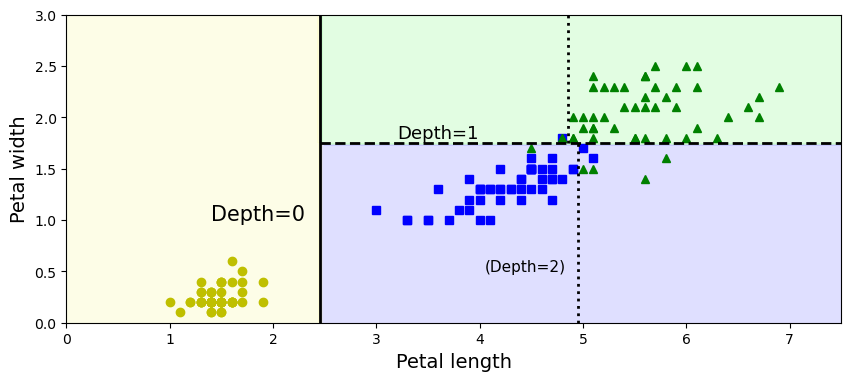

In [25]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(10, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

In [26]:
from sklearn import tree
p = tree.export_text(tree_clf)
print(p)

|--- feature_0 <= 2.45
|   |--- class: 0
|--- feature_0 >  2.45
|   |--- feature_1 <= 1.75
|   |   |--- class: 1
|   |--- feature_1 >  1.75
|   |   |--- class: 2



<a id="1.3"></a>
## 1.3. Переобучение дерева
Так как при построении дерева используется принцип жадной максимизации, то дерево достаточно легко переобучить

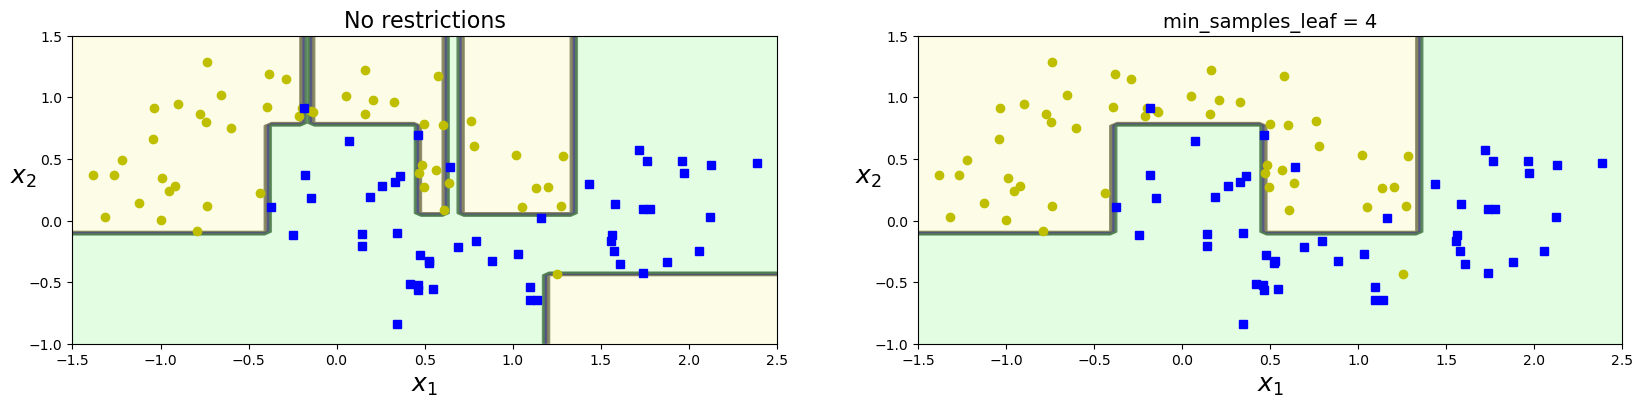

In [27]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(20, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.show()

<a id="1.4"></a>
## 1.4. Чувствительность дерева к выборкам

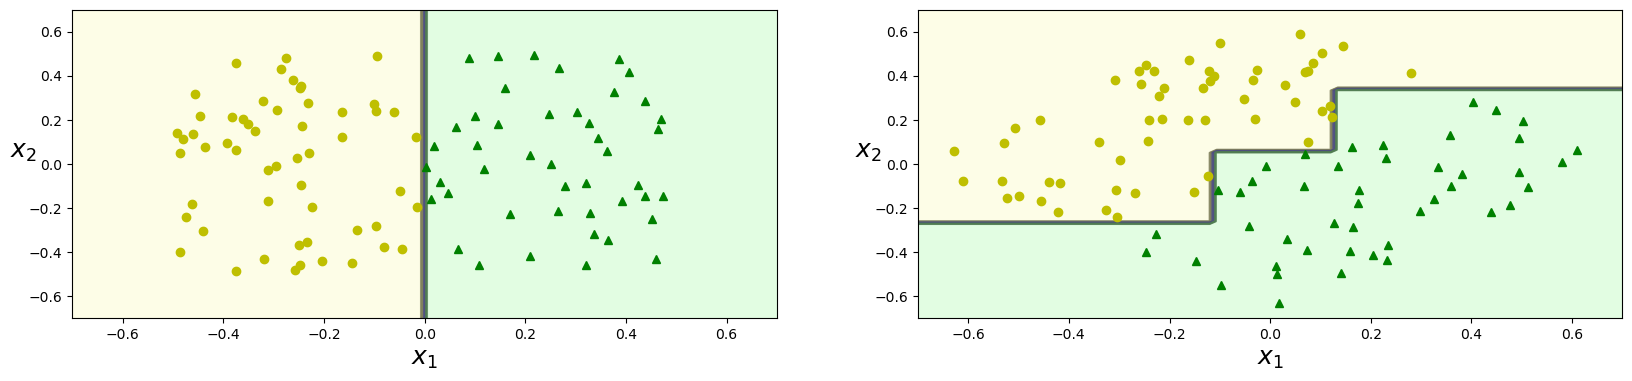

In [28]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(20, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.show()

<a id="1.5"></a>
## 1.5. Регрессионые решающие деревья

In [29]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [30]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

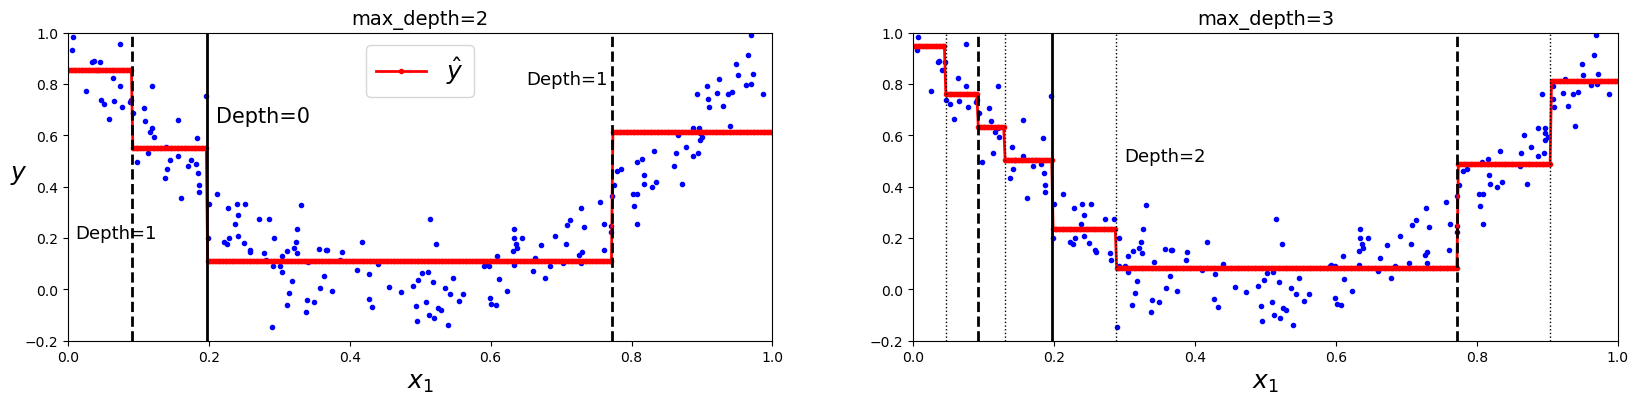

In [31]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(20, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)


plt.show()

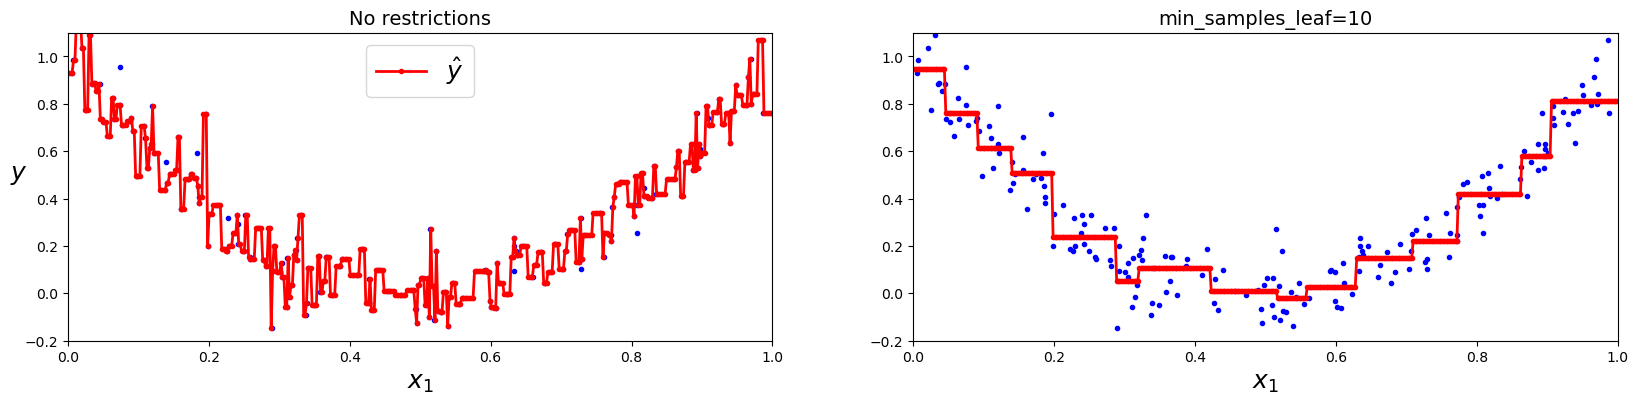

In [32]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(20, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

<a id="1.6"></a>
## 1.6. Применение на реальных данных

Будем использовать данныые с соревнования: [Прогнозирование задержек рейсов](https://www.kaggle.com/c/departure-delay2/leaderboard)   
Начем с того, что загрузим [данные](https://drive.google.com/drive/folders/186lhjqebHcN8f04eanXwJppNs8riUtoH?usp=sharing)

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
train = pd.read_csv("x_train.csv").fillna(0)
test = pd.read_csv("x_test.csv").fillna(0)
y = pd.read_csv("y_train.csv", index_col='id')

Посмотрим размеры выборок

In [35]:
train.shape, test.shape, y.shape

((1355730, 29), (581028, 29), (1355730, 1))

Посмотрим как выглядят данные

In [38]:
train.head(5)

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,6228008,2008,11,21,5,1500.0,1443,1557.0,1534,EV,...,7.0,16.0,0,N,0,17.0,0.0,6.0,0.0,0.0
1,4732721,2008,8,16,6,2000.0,1925,2149.0,2105,AA,...,7.0,14.0,0,N,0,31.0,0.0,9.0,0.0,4.0
2,472452,2008,1,26,6,1953.0,1900,2103.0,2020,9E,...,15.0,14.0,0,N,0,0.0,0.0,0.0,0.0,43.0
3,5300680,2008,9,15,1,1233.0,1215,1355.0,1350,AA,...,10.0,7.0,0,N,0,0.0,0.0,0.0,0.0,0.0
4,2364574,2008,4,13,7,1325.0,540,1604.0,752,CO,...,10.0,27.0,0,N,0,465.0,0.0,27.0,0.0,0.0


Для начала, мы рассмотрим переменные, заданные числами

In [39]:
train.describe()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,1.355730e+06,1355730.0,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,...,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06
mean,3.343270e+06,2008.0,6.113693e+00,1.574812e+01,3.984872e+00,1.518377e+03,1.467266e+03,1.604431e+03,1.634246e+03,2.184309e+03,...,7.656316e+02,6.784615e+00,1.822987e+01,3.171723e-04,4.021450e-03,1.233159e+01,2.378817e+00,9.667474e+00,5.820776e-02,1.628875e+01
std,2.065971e+06,0.0,3.482474e+00,8.769966e+00,1.996001e+00,4.502490e+02,4.246592e+02,5.553880e+02,4.644314e+02,1.943356e+03,...,5.742785e+02,5.259213e+00,1.433770e+01,1.780651e-02,6.328729e-02,3.607857e+01,1.738014e+01,2.803708e+01,1.656713e+00,3.586489e+01
min,0.000000e+00,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.519278e+06,2008.0,3.000000e+00,8.000000e+00,2.000000e+00,1.203000e+03,1.135000e+03,1.313000e+03,1.325000e+03,6.100000e+02,...,3.380000e+02,4.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.244459e+06,2008.0,6.000000e+00,1.600000e+01,4.000000e+00,1.545000e+03,1.510000e+03,1.714000e+03,1.705000e+03,1.544000e+03,...,6.060000e+02,5.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.974685e+06,2008.0,9.000000e+00,2.300000e+01,6.000000e+00,1.900000e+03,1.815000e+03,2.030000e+03,2.014000e+03,3.423000e+03,...,9.980000e+02,8.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.800000e+01
max,7.009727e+06,2008.0,1.200000e+01,3.100000e+01,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.400000e+03,9.742000e+03,...,4.962000e+03,2.400000e+02,3.830000e+02,1.000000e+00,1.000000e+00,2.436000e+03,1.297000e+03,1.357000e+03,3.920000e+02,1.316000e+03


In [40]:
# Проверим, прежде чем выкидывать признак:
print("Значений признака 'year' в трейне " ,  train['Year'].nunique())
print("Значений признака 'year' в тесте " ,  test['Year'].nunique())

Значений признака 'year' в трейне  1
Значений признака 'year' в тесте  1


Итак, какие выводы мы можем сделать? 
1. Признак `year` не несет вариативности в данные - удалим его
2. Признаки `Month`, `DayofMonth`, `DayOfWeek` скорее всего можно рассматривать как категориальные

In [41]:
train.drop('Year', axis=1, inplace=True)
test.drop('Year', axis=1, inplace=True)

In [42]:
types = train.dtypes
real_cols = list(types[types != 'object'].index.values)
cat_cols = list(types[types == 'object'].index.values)
types

Unnamed: 0             int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode      object
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object

Построим зависимость ошибки от максимальной глубины дерева

In [43]:
x_train, x_val, y_train, y_val = train_test_split(train, y, train_size=0.7, test_size=0.3, random_state=1)

In [44]:
dt = DecisionTreeRegressor()
dt.fit(x_train[real_cols], y_train)
mse_train = mean_squared_error(dt.predict(x_train[real_cols]), y_train)
mse_val = mean_squared_error(dt.predict(x_val[real_cols]), y_val)
print(mse_train, mse_val)

0.0 40.26022388922081


А теперь с регуляризацией

In [45]:
mse_train = []
mse_val = []

for i in range(5):
    dt = DecisionTreeRegressor(max_depth=i*5+1, min_samples_leaf=1000)
    dt.fit(x_train[real_cols], y_train)
    mse_train = np.append(mse_train, mean_squared_error(dt.predict(x_train[real_cols]), y_train))
    mse_val = np.append(mse_val, mean_squared_error(dt.predict(x_val[real_cols]), y_val))

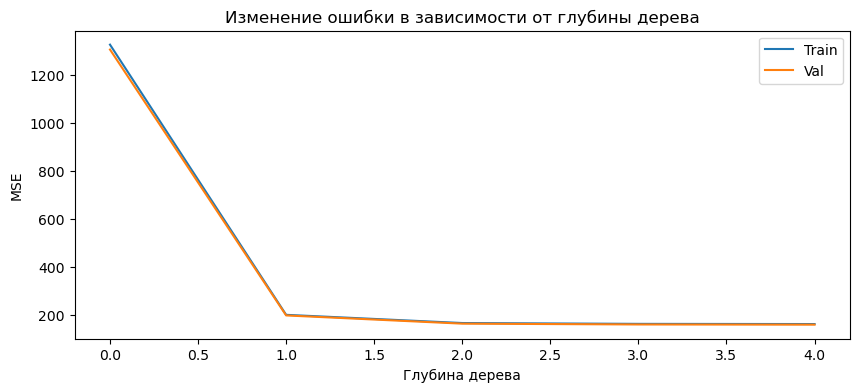

In [46]:
plt.figure(figsize=(10, 4))
plt.title('Изменение ошибки в зависимости от глубины дерева')

plt.plot(mse_train, label='Train')
plt.plot(mse_val, label='Val')
plt.legend()
plt.xlabel('Глубина дерева')
plt.ylabel('MSE')
plt.show()

### Работа с категориальными переменными

#### One hot encoding

Представим, что у нас есть признак, который принимает n значений, One hot encoding создает n признаков вместо изначального, при этом каждый новый признак принимает значения $\{0,1\}$, при этом все признаки каждого объекта будут равны 0, и только один 1

Возможно использовать `OneHotEncoder` из sklearn.preprocessing, но мы будем испольовать `pandas`

In [47]:
print(train['UniqueCarrier'].unique())
print(train['UniqueCarrier'].nunique())

['EV' 'AA' '9E' 'CO' 'MQ' 'OO' 'UA' 'B6' 'WN' 'OH' 'DL' 'US' 'AS' 'NW'
 'XE' 'F9' 'FL' 'YV' 'HA' 'AQ']
20


In [48]:
train = pd.get_dummies(train, drop_first=True, columns=['UniqueCarrier'])
test = pd.get_dummies(test, drop_first=True, columns=['UniqueCarrier'])

In [49]:
train.head()

,Unnamed: 0,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,TailNum,...,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
0,6228008,11,21,5,1500.0,1443,1557.0,1534,5055,N920EV,...,False,False,False,False,False,False,False,False,False,False
1,4732721,8,16,6,2000.0,1925,2149.0,2105,1043,N5BUAA,...,False,False,False,False,False,False,False,False,False,False
2,472452,1,26,6,1953.0,1900,2103.0,2020,5832,89429E,...,False,False,False,False,False,False,False,False,False,False
3,5300680,9,15,1,1233.0,1215,1355.0,1350,1501,N543AA,...,False,False,False,False,False,False,False,False,False,False
4,2364574,4,13,7,1325.0,540,1604.0,752,527,N14347,...,False,False,False,False,False,False,False,False,False,False


#### Кодирование переменных

In [53]:
train['Dest']

0          XNA
1          STL
2          DTW
3          DFW
4          IAH
          ... 
1355725    LGA
1355726    GPT
1355727    PIT
1355728    RDU
1355729    SDF
Name: Dest, Length: 1355730, dtype: object

In [50]:
#Создадим новую фичу 'route', которая будет содержать информацию как о точке отправления, так и о месте назначения
train['route'] = train['Origin'] + train['Dest']
test['route'] = test['Origin'] + test['Dest']
train['route'].nunique(), test['route'].nunique()

(5128, 4998)

In [51]:
train['route']

0          ATLXNA
1          MIASTL
2          TVCDTW
3          MSYDFW
4          BWIIAH
            ...  
1355725    RICLGA
1355726    FLLGPT
1355727    BWIPIT
1355728    ORDRDU
1355729    CLTSDF
Name: route, Length: 1355730, dtype: object

Давайте закодируем каждое значение 'route' средним значением целевой переменной для этого значения

In [54]:
code_route = pd.pivot_table(pd.concat([pd.DataFrame(train), y],axis=1), 
                            index='route', values='DelayTime', aggfunc='mean')

In [55]:
train['route'] = train['route'].apply(lambda x: code_route.loc[x][0] if x in code_route.index else 0)
test['route'] = test['route'].apply(lambda x: code_route.loc[x][0] if x in code_route.index else 0)

In [56]:
train.head()

,Unnamed: 0,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,TailNum,...,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,route
0,6228008,11,21,5,1500.0,1443,1557.0,1534,5055,N920EV,...,False,False,False,False,False,False,False,False,False,44.557103
1,4732721,8,16,6,2000.0,1925,2149.0,2105,1043,N5BUAA,...,False,False,False,False,False,False,False,False,False,52.067873
2,472452,1,26,6,1953.0,1900,2103.0,2020,5832,89429E,...,False,False,False,False,False,False,False,False,False,45.504000
3,5300680,9,15,1,1233.0,1215,1355.0,1350,1501,N543AA,...,False,False,False,False,False,False,False,False,False,43.261851
4,2364574,4,13,7,1325.0,540,1604.0,752,527,N14347,...,False,False,False,False,False,False,False,False,False,39.936255


### Обучим классификатор 

In [57]:
types = train.dtypes
real_cols = list(types[types != 'object'].index.values)
cat_cols = list(types[types == 'object'].index.values)
types

Unnamed: 0             int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode      object
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
UniqueCarrier_AA        bool
UniqueCarrier_AQ        bool
UniqueCarrier_AS        bool
UniqueCarrier_B6        bool
UniqueCarrier_CO        bool
UniqueCarrier_DL        bool
UniqueCarrier_EV        bool
UniqueCarrier_

In [58]:
x_train, x_val, y_train, y_val = train_test_split(train, y, train_size=0.7, test_size=0.3, random_state=1)

In [59]:
# Обучим классификатор
dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10000, min_samples_split=10000)
dt.fit(x_train[real_cols], y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=10000,
                      min_samples_split=10000)

In [60]:
mean_squared_error(dt.predict(x_val[real_cols]), y_val.values)

390.1711534763292

In [86]:
pd.Series(dt.predict(test[real_cols]), name='DelayTime').to_csv('predict.csv', index_label='id', header=True)

<a id="2"></a>
# 2. Композиция алгоритмов

<a id="2.1"></a>
## 2.1. Bias-Variance decomposition

In [61]:
import numpy as np
import matplotlib.pyplot as plt

In [62]:
def true_dep(x):
    return np.cos((x - 0.2)**2) + 0.2 / (1 + 50 * (x - 0.3)**2)

x_true = np.linspace(0, 1, 100)
y_true = true_dep(x_true)

def generate_n_datasets(num_datasets, dataset_length, noise_power=0.02):
    shape = (num_datasets, dataset_length, 1)
    x = np.random.uniform(size=shape)
    y = true_dep(x) + np.random.normal(scale=noise_power, size=shape)
    return x, y

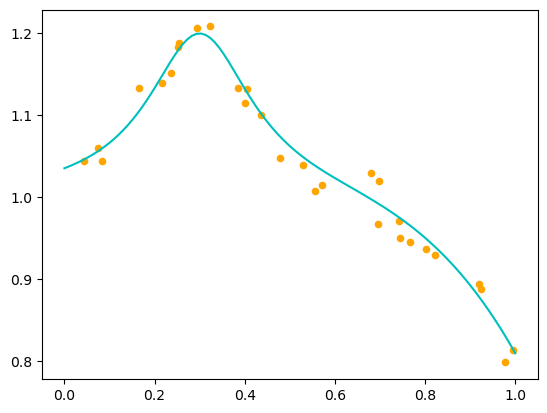

In [63]:
x, y = generate_n_datasets(1, 30)
plt.scatter(x.squeeze(), y.squeeze(), s=20, c='orange')
plt.plot(x_true, y_true, c='c', linewidth=1.5);

![](img/bvd.jpg)
![](img/example_bvd.png)

In [64]:
from copy import deepcopy
from tqdm import tqdm, trange

In [65]:
def calc_bias2_variance(model, datasets_X, datasets_y):
    preds = []
    for X, y in tqdm(zip(datasets_X, datasets_y), total=len(datasets_X)):
        m = deepcopy(model)
        m.fit(X, y)
        preds.append(m.predict(x_true[:,np.newaxis]).squeeze())
    preds = np.array(preds)
    mean_pred = preds.mean(axis=0)
    bias2 = (y_true - mean_pred)**2
    variance = ((preds - mean_pred[np.newaxis,...])**2).mean(axis=0)

    return bias2, variance, preds

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [67]:
MAX_POWER = 6
powers = np.arange(1, MAX_POWER+1)

bias2, variance, preds = [], [], []
for p in powers:
    model = Pipeline([
      ('poly', PolynomialFeatures(degree=p)),
      ('linear', LinearRegression())
    ])

    b2, v, p = calc_bias2_variance(model, *generate_n_datasets(1000, 20))
    bias2.append(b2)
    variance.append(v)
    preds.append(p)

bias2 = np.array(bias2)
variance = np.array(variance)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 547.41it/s]


6it [00:03,  1.57it/s]


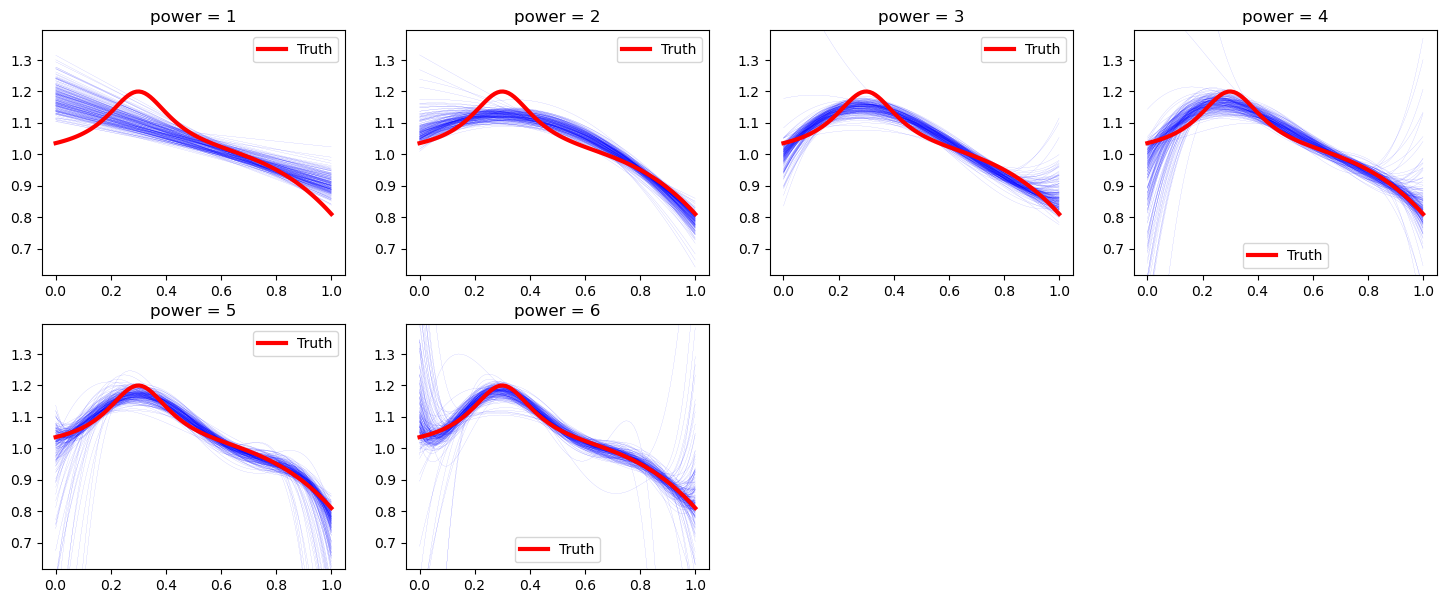

In [68]:
ncols = 4
nrows = int(np.ceil(len(powers) / ncols))

plt.figure(figsize=(18, 3.5 * nrows))

yrange = y_true.max() - y_true.min()

for i, (pred, pow) in tqdm(enumerate(zip(preds, powers), 1)):
    plt.subplot(nrows, ncols, i)
    for p in pred[np.random.choice(len(pred), size=200, replace=False)]:
        plt.plot(x_true, p, linewidth=0.05, c='b');
    plt.plot(x_true, y_true, linewidth=3, label='Truth', c='r')
    plt.ylim(y_true.min() - 0.5 * yrange, y_true.max() + 0.5 * yrange)
    plt.title('power = {}'.format(pow))
    plt.legend();

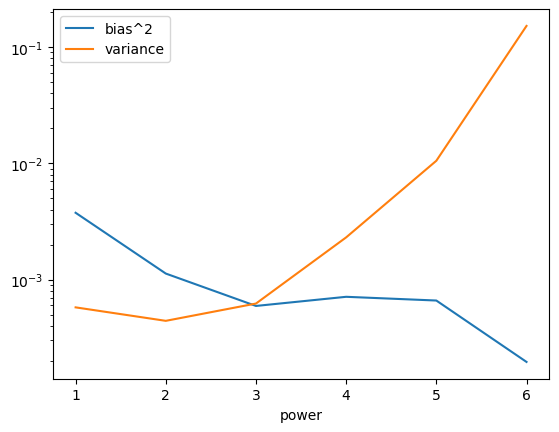

In [69]:
plt.plot(powers, bias2.mean(axis=1), label='bias^2')
plt.plot(powers, variance.mean(axis=1), label='variance')
plt.legend()
plt.yscale('log')
plt.xlabel('power');

<a id="2.2"></a>
## 2.2. Предобработка данных

In [70]:
data = pd.read_csv('flight_delays_train.csv')

In [71]:
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [72]:
# Загрузим данные и проведем предобработки: 
data['dep_delayed_15min'] = data['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)
data['Month'] = data['Month'].str.replace('c-', '').astype('int16')
data['DayofMonth'] = data['DayofMonth'].str.replace('c-', '').astype('int16')
data['DayOfWeek'] = data['DayOfWeek'].str.replace('c-', '').astype('int16')

data['UniqueCarrier'] = pd.factorize(data['UniqueCarrier'])[0]
data['Origin'] = pd.factorize(data['Origin'])[0]
data['Dest'] = pd.factorize(data['Dest'])[0]

# DepTime пусть будет более вещественным числом (так как 60 минут в часах)
data['DepTime_real'] = data['DepTime'].apply(lambda x: int(x/100)+((x/100-int(x/100))*100)/60)
data.drop('DepTime', axis=1, inplace=True)


x = data.drop('dep_delayed_15min', axis=1)
y = data['dep_delayed_15min'].values


data.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepTime_real
0,8,21,7,0,0,0,732,0,19.566667
1,4,20,3,1,1,1,834,0,15.800000
2,9,2,5,2,2,2,416,0,14.366667
3,11,25,6,3,3,3,872,0,10.250000
4,10,7,6,4,4,4,423,1,18.466667


<a id="2.3"></a>
## 2.3. Bootstrap
Посмотрим плотности распредления переменной "Время Вылета" для задержки менее 15 минут и более

In [100]:
!pip install seaborn

In [73]:
import seaborn as sns

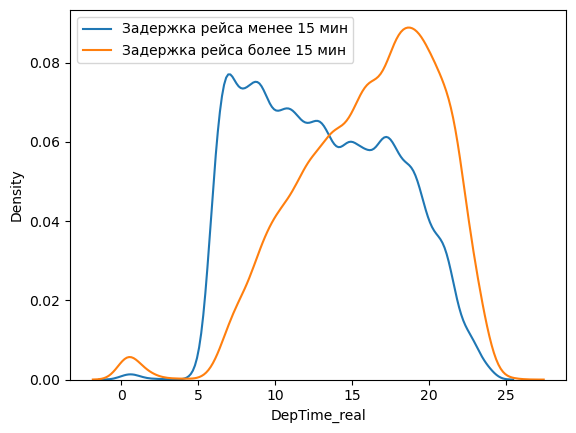

In [74]:
sns.kdeplot(data[data['dep_delayed_15min'] == 0]['DepTime_real'], label='Задержка рейса менее 15 мин')
sns.kdeplot(data[data['dep_delayed_15min'] == 1]['DepTime_real'], label='Задержка рейса более 15 мин')
plt.legend()
plt.show()

In [75]:
print('Среднее', data[data['dep_delayed_15min'] == 1]['DepTime_real'].mean())
print('Среднее', data[data['dep_delayed_15min'] == 0]['DepTime_real'].mean())

Среднее 16.002944934537563
Среднее 13.049982500782317


![img](img/bootstrap.jpg)

**Задание 2**: Реализуйте функцию бустрапирования n выборок размера size.

In [76]:
def get_bootstrap_samples(data, n_samples, size):
    # функция для генерации подвыборок с помощью бутстрэпа
    samples = # YOUR_CODE_HERE
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [77]:
# сохранение в отдельные numpy массивы данных по вылетам с задержками и без 
no_delayed = data[data['dep_delayed_15min'] == 0]['DepTime_real'].values
delayed = data[data['dep_delayed_15min'] == 1]['DepTime_real'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем 1000 выборок с помощью бутстрэпа и сразу считаем по каждой из них среднее
no_delayed_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(no_delayed, 1000, len(no_delayed)//2)]
delayed_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(delayed, 1000, len(delayed)//2)]

In [78]:
#  выводим интервальную оценку среднего
print("Среднее время вылета по рейсам без задержек в интервале:",  stat_intervals(no_delayed_mean_scores, 0.05))
print("Среднее время вылета по рейсам с задержками в интервале:",  stat_intervals(delayed_mean_scores, 0.05))

Среднее время вылета по рейсам без задержек в интервале: [13.00575371 13.09418725]
Среднее время вылета по рейсам с задержками в интервале: [15.91076686 16.09495016]


<a id="2.4"></a>
## 2.4. Bagging (Bootstrap aggregating)

In [79]:
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, accuracy_score

![](img/bagging.jpg)

In [80]:
tree = DecisionTreeClassifier()

In [81]:
# Посчитаем значение метрики accuracy на кроссвалидаци для дерева
np.mean(cross_val_score(tree, x, y, cv=3))

0.7278600013455585

In [82]:
# Посчитаем значение метрики accuracy на кроссвалидаци для композиции деревьев построенной на бутстрап выборке
bag_of_trees = BaggingClassifier(tree)
np.mean(cross_val_score(bag_of_trees, x, y, cv=3))

0.8097700002619513

In [83]:
# Для ограниченного числа признаков
tree = DecisionTreeClassifier(max_features=int(x.shape[1]**0.5))
bag_of_trees = BaggingClassifier(tree)
np.mean(cross_val_score(bag_of_trees, x, y, cv=3))

0.8092100066617753

<a id="2.5"></a>
## 2.5. Random Forest

![](img/random_forest.jpg)

### Как можно добавить случайности? 

Например: Ограничить кол-во признаков, по которым проводить разбиение

In [84]:
RandomForestClassifier()

RandomForestClassifier()

In [85]:
forest = RandomForestClassifier(n_jobs=-1)
np.mean(cross_val_score(forest, x,y, cv=3, n_jobs=-1))

0.8182300035636104

### Что будет, если ограничить глубину построенных деревьев? 

In [120]:
#Разделим выборку на обущающую и тестовую
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, \
                                                    shuffle=True, random_state=21)

**Задание 3**: Обучите 16 классификаторов RandomForestClassifier и посчитайте для них accuracy_score на обучающей и на тестовой выборке. Запустите ячейку дальше. Какой график вы видите?

In [121]:
train_score = []
test_score = []

for i in range(1,16):
    # YOUR_CODE_HERE

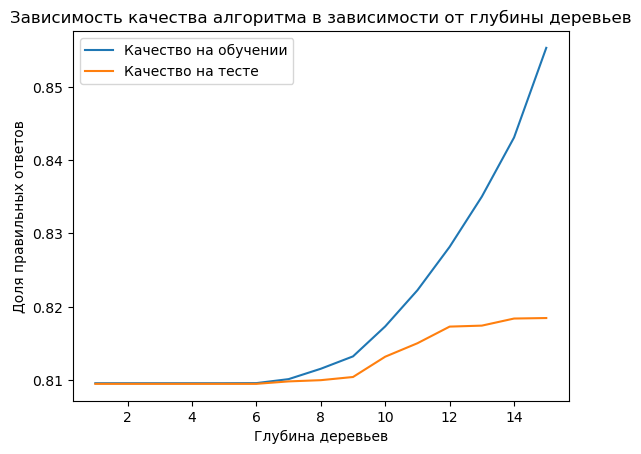

In [122]:
plt.title('Зависимость качества алгоритма в зависимости от глубины деревьев')
plt.plot(range(1,16), train_score, label="Качество на обучении")
plt.plot(range(1,16), test_score, label="Качество на тесте")
plt.legend()
plt.ylabel('Доля правильных ответов')
plt.xlabel('Глубина деревьев')
plt.show()

### Важность признкаов
Одно из замечательных свойств, возможность посмотреть важность каждого признака, оценив вклад

**Как это работает?** (ваши предположения) 

In [86]:
feature_importances = pd.DataFrame(forest.feature_importances_, index=x_train.columns, columns=['Importance']
            ).sort_values('Importance', ascending=False)

sns.barplot(y=feature_importances['Importance'], x=feature_importances.index, palette="rocket")
plt.ylabel('Важность')
plt.xlabel('Признак')
plt.xticks(rotation=90)
plt.show()

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<a id="2.6"></a>
## 2.6. Out-of-bag error

Какая часть выборки попадает в обучение при Bootstrap?

Забегая вперед, отметим, что при использовании случайных лесов нет необходимости в кросс-валидации или в отдельном тестовом наборе, чтобы получить несмещенную оценку ошибки набора тестов. Посмотрим, как получается "внутренняя" оценка модели во время ее обучения.


Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева.


Это можно легко доказать: пусть в выборке $\large \ell$ объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект — с вероятностью $\large\frac{1}{\ell}.$ Вероятность того, что объект НЕ попадет в подвыборку (т.е. его не взяли $\large \ell$ раз): $\large (1 - \frac{1}{\ell})^\ell$. При $\large \ell \rightarrow +\infty$ получаем один из "замечательных" пределов $\large \frac{1}{e}$. Тогда вероятность попадания конкретного объекта в подвыборку $\large \approx 1 - \frac{1}{e} \approx 63\%$.

Получается, что каждый базовый алгоритм обучается на ~63% исходных объектов. Значит, на оставшихся ~37% его можно сразу проверять. Out-of-Bag оценка — это усредненная оценка базовых алгоритмов на тех ~37% данных, на которых они не обучались.

In [125]:
tree = DecisionTreeClassifier()
bag_of_trees = BaggingClassifier(tree, n_estimators=20, oob_score=True, n_jobs=-1)

In [126]:
bag_of_trees.fit(x,y)
bag_of_trees.oob_score_

0.80382

<a id="2.7"></a>
## 2.7. Ассамблирование алгоритмов разных классов (Blending, Stacking)

### Определим базовые алгоритмы

In [127]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=21)

In [128]:
from sklearn import naive_bayes

sklearn_nb = naive_bayes.GaussianNB()
sklearn_nb.fit(x_train, y_train)
sklearn_nb_pred = sklearn_nb.predict(x_test)
sklearn_nb_pred_proba = sklearn_nb.predict_proba(x_test)
accuracy_score(sklearn_nb_pred, y_test)

0.80672

In [129]:
from sklearn.neighbors import KNeighborsClassifier

sklearn_knn = KNeighborsClassifier()
sklearn_knn.fit(x_train, y_train)
sklearn_knn_pred = sklearn_knn.predict(x_test)
sklearn_knn_pred_proba = sklearn_knn.predict_proba(x_test)
accuracy_score(sklearn_knn_pred, y_test)

0.78208

In [130]:
from sklearn.linear_model import LogisticRegression

sklearn_lс = LogisticRegression()
sklearn_lс.fit(x_train, y_train)
sklearn_lс_pred = sklearn_lс.predict(x_test)
sklearn_lс_pred_proba = sklearn_lс.predict_proba(x_test)
accuracy_score(sklearn_lс_pred, y_test)

0.80708

In [131]:
from sklearn.svm import SVC

sklearn_svc = SVC(kernel='linear', C=1e5, max_iter=100, probability=True)
sklearn_svc.fit(x_train, y_train)
sklearn_svc_pred = sklearn_svc.predict(x_test)
sklearn_svc_pred_proba = sklearn_svc.predict_proba(x_test)
accuracy_score(sklearn_svc_pred, y_test)

0.64332

In [132]:
from sklearn.tree import DecisionTreeClassifier

sklearn_tree = DecisionTreeClassifier()
sklearn_tree.fit(x_train, y_train)
sklearn_tree_pred = sklearn_tree.predict(x_test)
sklearn_tree_pred_proba = sklearn_tree.predict_proba(x_test)
accuracy_score(sklearn_tree_pred, y_test)

0.73036

In [133]:
d = {'sklearn_nb': sklearn_nb_pred, 'sklearn_knn': sklearn_knn_pred, 'sklearn_knn': sklearn_knn_pred, 'sklearn_lс': sklearn_lс_pred, 'sklearn_svc': sklearn_svc_pred, 'sklearn_tree': sklearn_tree_pred}
df = pd.DataFrame(data=d)
df

,sklearn_nb,sklearn_knn,sklearn_lс,sklearn_svc,sklearn_tree
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,1,0
3,0,0,0,0,1
4,0,0,0,0,0
...,...,...,...,...,...
24995,0,0,0,0,0
24996,0,0,0,1,1
24997,0,0,0,0,0
24998,0,0,0,0,0


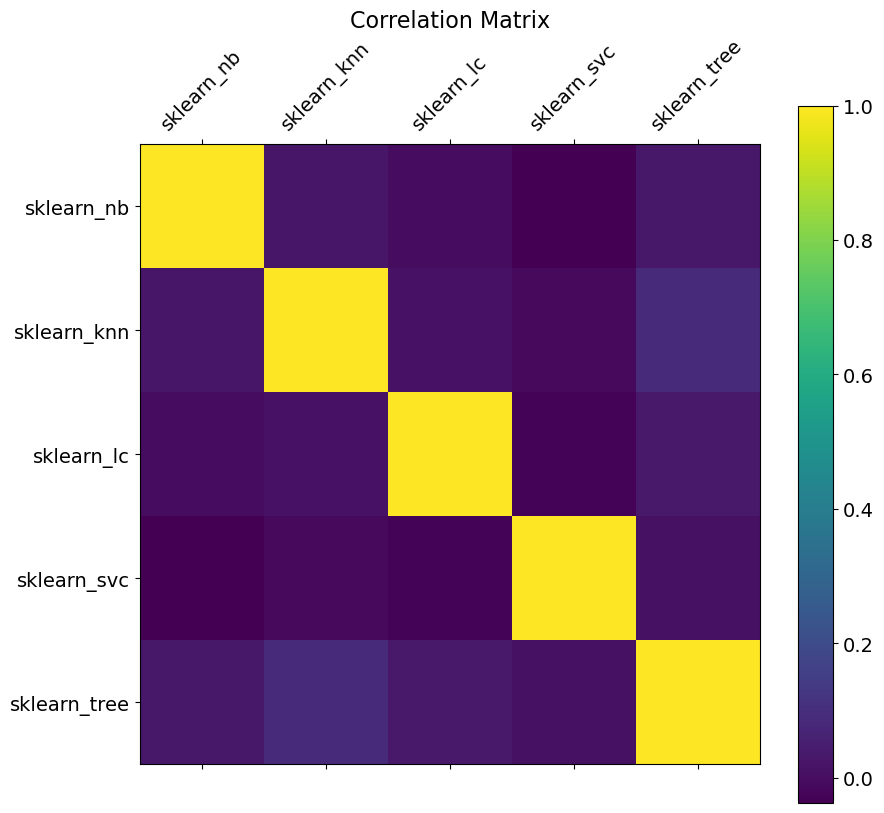

In [134]:
f = plt.figure(figsize=(10, 9))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [135]:
df.corr()

,sklearn_nb,sklearn_knn,sklearn_lс,sklearn_svc,sklearn_tree
sklearn_nb,1.000000,0.025019,-0.003727,-0.037498,0.028816
sklearn_knn,0.025019,1.000000,0.011603,-0.011308,0.091228
sklearn_lс,-0.003727,0.011603,1.000000,-0.025870,0.033273
sklearn_svc,-0.037498,-0.011308,-0.025870,1.000000,0.007380
sklearn_tree,0.028816,0.091228,0.033273,0.007380,1.000000


### Применим подход Blending

$$ f(x) = \sum_{i=1}^{n} \omega_{i}*h_i(x) $$
при этом $ \sum_{i=1}^{n} \omega_{i} = 1$, $ \omega_{i} \in [0, 1] $

**Задание 4**: Реализуйте blending на основе sklearn__algo__pred_proba и на sklearn__algo__pred

In [150]:
blend_pred_proba = #YOUR_CODE_HERE
blend_pred = #YOUR_CODE_HERE

In [151]:
accuracy_score(blend_pred, y_test)

0.80648

### Применим подход Stacking

In [152]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=21)

In [153]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle=True, random_state=21)

In [154]:
sklearn_nb.fit(x_train, y_train)
sklearn_nb_pred = sklearn_nb.predict(x_val)

In [155]:
sklearn_knn.fit(x_train, y_train)
sklearn_knn_pred = sklearn_knn.predict(x_val)

In [156]:
sklearn_lс.fit(x_train, y_train)
sklearn_lс_pred = sklearn_lс.predict(x_val)

In [157]:
sklearn_svc.fit(x_train, y_train)
sklearn_svc_pred = sklearn_svc.predict(x_val)

In [158]:
sklearn_tree.fit(x_train, y_train)
sklearn_tree_pred = sklearn_tree.predict(x_val)

In [159]:
d = {'sklearn_nb': sklearn_nb_pred, 'sklearn_knn': sklearn_knn_pred, 'sklearn_knn': sklearn_knn_pred, 'sklearn_lс': sklearn_lс_pred, 'sklearn_svc': sklearn_svc_pred, 'sklearn_tree': sklearn_tree_pred}
df = pd.DataFrame(data=d)
df

,sklearn_nb,sklearn_knn,sklearn_lс,sklearn_svc,sklearn_tree
0,0,0,0,1,0
1,0,0,0,1,1
2,0,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,0
...,...,...,...,...,...
18745,0,0,0,1,0
18746,0,0,0,1,0
18747,0,0,0,0,0
18748,0,0,0,0,0


In [160]:
import torch
from torch import nn
import torch.nn.functional as F

In [161]:
# create a network that stacks layers on top of each other
model = nn.Sequential()

# add first "dense" layer with 64 input units and 1 output unit. 
model.add_module('l1', nn.Linear(5, 1))

# add softmax activation for probabilities. Normalize over axis 1
# note: layer names must be unique
model.add_module('l2', nn.Sigmoid())

In [162]:
opt = torch.optim.SGD(model.parameters(), lr=1e-3)

In [163]:
df.values[100]

array([0, 0, 0, 0, 1], dtype=int64)

In [164]:
history = []

for i in range(10000):
    
    # sample 256 random predicts
    ix = np.random.randint(0, df.shape[0], 256)
    x_batch = torch.tensor(df.values[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_val[ix], dtype=torch.float32)
    
    # predict probabilities
    y_predicted = model(x_batch)[:, 0]
        
    # compute loss, just like before
    loss = F.binary_cross_entropy(y_predicted, y_batch)
    
    loss.backward()
    
    opt.step()

    opt.zero_grad()

    history.append(loss.data.numpy())
    
    if i % 1000 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 0.738
step #1000 | mean loss = 0.638
step #2000 | mean loss = 0.582
step #3000 | mean loss = 0.546
step #4000 | mean loss = 0.525
step #5000 | mean loss = 0.515
step #6000 | mean loss = 0.510
step #7000 | mean loss = 0.508
step #8000 | mean loss = 0.493
step #9000 | mean loss = 0.503


In [165]:
model.eval()

Sequential(
  (l1): Linear(in_features=5, out_features=1, bias=True)
  (l2): Sigmoid()
)

In [166]:
sklearn_nb_pred = sklearn_nb.predict(x_test)
sklearn_knn_pred = sklearn_knn.predict(x_test)
sklearn_lс_pred = sklearn_lс.predict(x_test)
sklearn_svc_pred = sklearn_svc.predict(x_test)
sklearn_tree_pred = sklearn_tree.predict(x_test)

In [167]:
d = {'sklearn_nb': sklearn_nb_pred, 'sklearn_knn': sklearn_knn_pred, 'sklearn_knn': sklearn_knn_pred, 'sklearn_lс': sklearn_lс_pred, 'sklearn_svc': sklearn_svc_pred, 'sklearn_tree': sklearn_tree_pred}
df = pd.DataFrame(data=d)

In [170]:
stacking_pred_proba = model(torch.tensor(df.values, dtype=torch.float32))
stacking_pred = np.array(stacking_pred_proba.detach().numpy(), dtype=np.int32)

In [171]:
accuracy_score(stacking_pred, y_test)

0.80792

### Что будет, если среди наших алгоритмов будет 1 сильный?
Если среди алгоритмов в ансамбле типа стэкинг (stacking) присутствует один сильный алгоритм, который значительно лучше других, это может оказывать как положительную, так и отрицательную поддержку на общий результат ансамбля. Рассмотрим несколько аспектов:<br><br>### Положительная сторона:<br>1. <strong>Улучшение итоговой модели</strong>: Сильный алгоритм может дать значительный вклад в предсказания ансамбля, если его выводы будут учитываться в конечных предсказаниях. Это может повысить общую точность модели.<br>  <br>2. <strong>Снижение разнообразия</strong>: Если сильный алгоритм дает более точные оценки, его влияние может помочь исправить ошибки, которые допускают другие более слабые алгоритмы, способствуя более стабильным и надежным предсказаниям.<br><br>### Отрицательная сторона:<br>1. <strong>Преобладание одного алгоритма</strong>: Если один алгоритм значительно сильнее остальных, он может доминировать при оценке, и остальные модели могут оказаться менее влиятельными или даже игнорироваться. Это может привести к недостаточной диверсификации ансамбля.<br><br>2. <strong>Проблемы с переобучением</strong>: Сильный алгоритм, если он переобучен на данных, может вносить много шума в предсказания, особенно если данные имеют аномалии. Это может негативно сказаться на обобщающей способности всего ансамбля.<br><br>3. <strong>Зависимость от одного алгоритма</strong>: Если сильный алгоритм не справляется с некоторыми сценариями или особенностями данных (например, если он плохо обрабатывает определенные особенности из-за неполных данных), то общая производительность ансамбля может пострадать.<br><br>### Рекомендации:<br>- <strong>Балансировка</strong>: Важно учитывать, чтобы Powerful (сильный) алгоритм не доминировал в ансамбле. Можно применять методы, такие как взвешивание или ограничение его вклада в окончательное предсказание.<br>  <br>- <strong>Использование мета-модели</strong>: В качестве мета-модели, которая объединяет предсказания базовых моделей, стоит использовать алгоритм, который лучше справляется с переобучением, например, регуляризированные методы.<br><br>Таким образом, наличие одного сильного алгоритма в стэкинге может как способствовать улучшению качества предсказаний, так и негативно сказываться на производительности ансамбля, если не учитывать соответствующие факторы.

<a id="3"></a>
# 3. Полезные ссылки 

**Что посмотреть?**
1. CatBoost от Яндекса: https://www.youtube.com/watch?v=UYDwhuyWYSo
2. Лекции от Радослава Нейчева про деревья и ансамбли:  
   https://www.youtube.com/watch?v=sJNE-Pgs4bI&list=PL4_hYwCyhAvYAPsfeaIWH6cBb8Js9lLNt&index=6  
   https://www.youtube.com/watch?v=I9FF-3UAm4o

**Что почитать?**
1. [Ноутбук по решающим деревьям](https://notebooks.githubusercontent.com/view/ipynb?browser=unknown_browser&bypass_fastly=true&color_mode=auto&commit=bc67fe6b872655e8e5628ec14b01fde407c5eb3c&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6976616e2d6d616764612f6d6c636f757273655f6f70656e5f686f6d65776f726b732f626336376665366238373236353565386535363238656331346230316664653430376335656233632f6877335f73657373696f6e335f6465636973696f6e5f74726565732e6970796e62&logged_in=false&nwo=ivan-magda%2Fmlcourse_open_homeworks&path=hw3_session3_decision_trees.ipynb&platform=unknown_platform&repository_id=120884692&repository_type=Repository&version=0)
2. Рещающие деревья в sklearn:  
   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html  
   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
3. [Ноутбук про ансамбли](https://www.kaggle.com/code/satishgunjal/ensemble-learning-bagging-boosting-stacking)